In [8]:
library(tidyverse)
library(estimatr)
library(broom)
# STATISTICAL CONSTANTS
alpha <- 0.05
power_thresh <- 0.80

# STUDY DESIGN 
assignment_func <- NULL 
effect_sizes <- c(0.03,0.05,0.10,0.15)

ss_per_period <- seq(50, 4000, by = 100)
num_periods <- 4
num_clusters <- 60
num_per_cluster <- ss_per_period/num_clusters


data is generated according to the function

$Y_{ijk} = \alpha_i + \beta_j + X_{ij} \theta = 0 - 0.05 + X_{ij}\times \theta, \theta \in \{0.03,0.05,0.10,0.15\}$

where $Y_{ijk}$ is the outcome for individual $k$ at time period $j$ who lives in zip code $i$. $\alpha_i$ is a zip code effect, $\beta_j$ is a period effect, $X_ij$ is the treatment indicator for zip code $i$ at time period $j$ and $\theta$ is the treatment effect.

In [ ]:

# DATA GENERATION
analysis_formula <- 'completion_rate ~ treatment + period + zip'

data_gen_func <- function(effect_size,ss_per_period,num_periods,num_clusters) {
  tib <- tibble(
      # Assign an index from 1 to the number of observations per perid
      index=1:ss_per_period,
      # Sample zipcodes randomly
      zip = sample(1:num_clusters, ss_per_period, replace = TRUE)
    ) %>%
    mutate(
      # We'll just make SVI a function of ones zip code
      svi = zip*1.5) %>%
    # Repeat for each timeperiod
    crossing(.,data.frame(period=1:num_periods)) %>%
    select(period,zip,svi)

  # Treatment assignment happens at the zip code level
  group_data <- tib %>%
    group_by(zip) %>%
    # There's probably a better way to do this than doing this useuless groupby but here we are
    summarize(mean_svi = mean(svi)) %>%
    # Crossover point is the time period where the treatment turns on/off
    # UPDATE HERE IF YOU WANT TO CHANGE TREATMENT ASSIGNMENT MECHANISM (IE A FUNCTION OF SVI)
    mutate(crossover = sample(c(2,3),
        nrow(.),
        replace=TRUE)) %>%
    select(zip,crossover)
  
  tib <- tib %>%
    left_join(group_data,by='zip') %>%
    mutate(treatment = as.integer(crossover > period)) %>%
    # UPDATE HERE IF YOU WANT TO ADD ZIP CODE LEVEL EFFECTS/TIME EFFECTS
    mutate(completion_rate = effect_size*treatment+(rbinom(nrow(.),100,0.45)/100) - 0.05*period + rnorm(nrow(.), mean = 0, sd = (zip/100)),
        num_secondary_tests = effect_size*treatment + rpois(nrow(.), 2) - 0.05*period + rnorm(nrow(.), mean = 0, sd =(zip/100))) %>%
    return()
}


# SIMULATION CONSTANTS
num_sims_p_step <- 200

In [2]:
calc_power <- function(data_func,num_sims=500,form='Y~X',alpha=0.05) {
  sig_results <- c() %>% as.numeric()
  for (i in 1:num_sims) {
    # Have to re-create the data EVERY TIME or it will just be the same data over and over
    mock_data <- data_func()
    # Run the analysis
    model <- lm_robust(as.formula(form), data = mock_data)
    # Get the results
    sig_results[i] <-tidy(model)$p.value[2] <= alpha
  }
  
  tibble(
    power=mean(sig_results),
    sd=sd(sig_results),
    n=num_sims,
    se=sd(sig_results)/sqrt(num_sims)) %>% 
  mutate(
    low_95=power-(1.96*se),
    high_95=power+(1.96*se)
  ) %>%
  return()
}

term,estimate,std.error,statistic,p.value,conf.low,conf.high,df,outcome
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),0.4811055193,0.0207994656,23.1306673,1.238714e-114,0.4403331441,0.521877895,7996,completion_rate
treatment,0.1291891028,0.0137175196,9.4178180,5.911599e-21,0.1022991881,0.156079017,7996,completion_rate
period,-0.0567788516,0.0061261513,-9.2682745,2.391497e-20,-0.0687877052,-0.044769998,7996,completion_rate
zip,-0.0002141332,0.0002405854,-0.8900504,3.734656e-01,-0.0006857434,0.000257477,7996,completion_rate


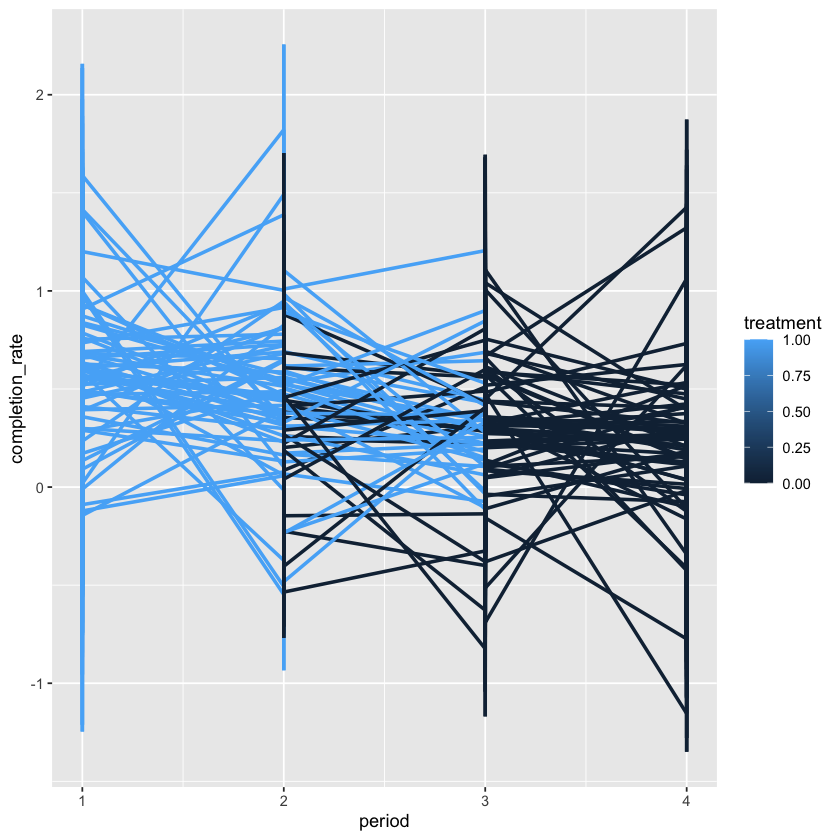

In [3]:
ex_data <- data_gen_func(0.15,2000,num_periods,num_clusters)
ggplot(ex_data,
     aes(x = period, y = completion_rate,group=zip,color=treatment)) +
     geom_line(size=1)
m <- lm_robust(as.formula(analysis_formula),data=ex_data)
tidy(m)

In [4]:
calc_power(function() data_gen_func(0.15,100,num_periods,num_clusters),
        num_sims=num_sims_p_step,
        form=analysis_formula)

power,sd,n,se,low_95,high_95
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6,0.4911273,200,0.03472794,0.5319332,0.6680668


In [5]:
# Get all pairs of
params <- expand.grid(list(es=effect_sizes,ss_per_period=ss_per_period))
# You're passing in the parameterized function, but not actually calling it yet (so it creates a new random dataset each time)
create_generator <- function(es,ss,np,nc) function() data_gen_func(es,ss,np,nc)
# Create the generators
data_generators <- mapply(create_generator,
    params$es,
    params$ss,
    num_periods,
    num_clusters)
    
power_res <- mapply(calc_power,
    data_generators,
    num_sims=num_sims_p_step,
    form=analysis_formula)  %>% t() %>% as_tibble() %>% unnest()
    
results <- cbind(params,power_res)  %>% 
    mutate(num_per_cluster=ceiling(ss_per_period/num_clusters))
head(results)

Warning message:
"`cols` is now required when using unnest().
Please use `cols = c(power, sd, n, se, low_95, high_95)`"


,es,ss_per_period,power,sd,n,se,low_95,high_95,num_per_cluster
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.03,50,0.085,0.2795815,200,0.01976940,0.04625198,0.1237480,1
2,0.05,50,0.090,0.2868999,200,0.02028689,0.05023770,0.1297623,1
3,0.10,50,0.195,0.3971949,200,0.02808592,0.13995159,0.2500484,1
4,0.15,50,0.430,0.4963181,200,0.03509499,0.36121382,0.4987862,1
5,0.03,150,0.095,0.2939507,200,0.02078546,0.05426051,0.1357395,3
6,0.05,150,0.150,0.3579675,200,0.02531212,0.10038824,0.1996118,3


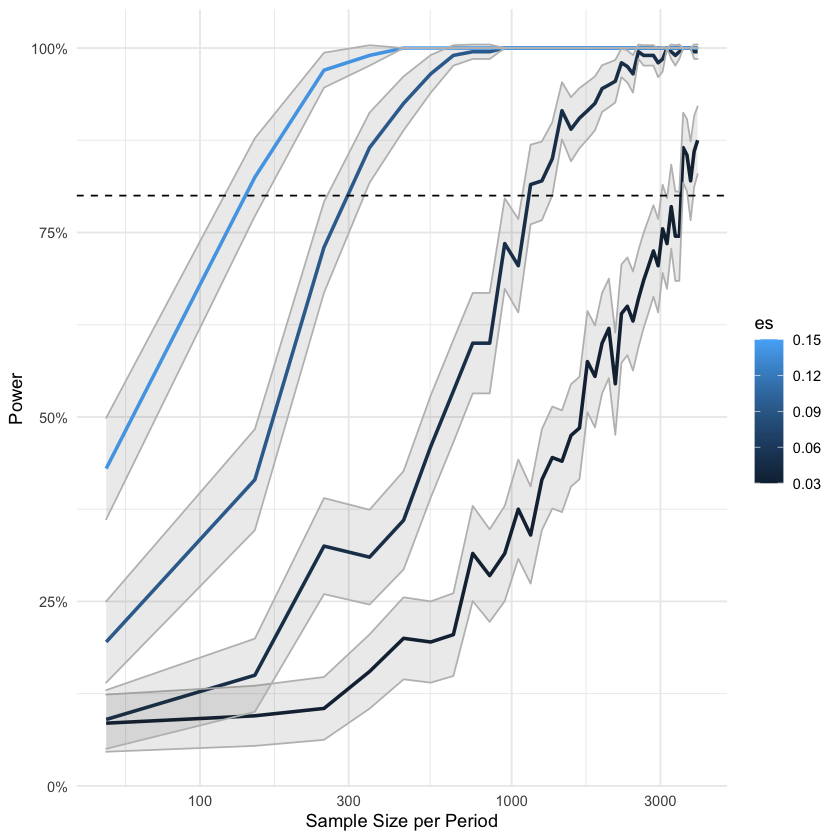

In [13]:
ggplot(results,
     aes(x = ss_per_period, y = power,group=es,color=es)) +
     geom_line(size=1) +
     geom_ribbon(aes(ymin = low_95, ymax = high_95),color='grey', alpha = 0.1) +
     # add a horizontal line at 90%
     geom_hline(aes(yintercept = power_thresh), linetype = 'dashed') + 
     scale_x_continuous(trans='log10') +
     # Prettify!
     theme_minimal() + 
     scale_y_continuous(labels = scales::percent) + 
     labs(x = 'Sample Size per Period', y = 'Power')

In [10]:
write.csv(results,'sw-0.05_time_effect-results.csv')